# Metastatic Cancer Detection using Binary Image Classification
## Project Summary
The goal is to train a binary image classifier to determine whether a 96×96 pixel RGB patch of a digital pathology slide contains metastatic tissue. The training set consists of 220,025 image patches collected from lymph‑node biopsies. Each sample is labelled with `0` (no metastasis) or `1` (metastasis). According to the competition description, a positive label indicates that the central 32×32 pixel region of the patch contains at least one pixel of tumour tissue; tumour tissue in the outer region does not influence the label. The outer region is provided so that fully convolutional models can be trained without zero padding.

The project is follows these steps:  
1. **Data Summary** – Describe the dataset, labeling, and how images are split into training and validation sets
2. **Exploratory Data Analysis (EDA)** – Examine class balance, color distributions, and image artefacts to guide preprocessing
3. **Baseline CNN Model** – Build a simple CNN from scratch to establish initial performance metrics
4. **Hyperparameter Tuning** - Optimize learning rate and dropout rate using Keras Tuner to improve model performance
5. **CNN Transfer Models** - Appliy pre-trained models (ResNet50, DenseNet169) to leverage learned image features
6. **Results and Analysis** – Compare model performance using evaluation metrics and visualizations
7. **Conclusion** – Summarize results and identifies opportunities for further model improvement

## Data Summary  
#### Import Python Libraries

In [ ]:
# Import core libraries and ML utilities
import os
import glob
import gc
import warnings
import re
import random
import math
import json
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

#### Data Source  
The datasets are sourced from the **Histopathologic Cancer Detection** Kaggle competition. The `train` and `test` folders contain image files in `.tif` format, while the accompanying `train_labels.csv` file provides the ground truth labels corresponding to the images in the `train` folder.

*Reference:*  
Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

#### Import Datasets

In [2]:
# Paths to data folders and labels file
train_images_path = './train/'
test_images_path  = './test/'
train_labels_csv  = './train/train_labels.csv'

# Load training labels
labels_df = pd.read_csv(train_labels_csv)

# Create a list of the file paths to the images in the train and test folders
train_tiff_file_path_names = glob.glob(os.path.join(train_images_path, '*.tif'))
test_tiff_file_path_names = glob.glob(os.path.join(test_images_path, '*.tif'))

print(f'Count of train images = {len(train_tiff_file_path_names):,}\nCount of test images = {len(test_tiff_file_path_names):,}')

Count of train images = 220,025
Count of test images = 57,458


#### Configure Constant Variables
- Define the exogenous varibles that will be used throughout the modeling and analysis.
- Sample size has been set at 55,000 which represents ~ 25% of the dataset

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

# Image config
IMG_SIZE = 96 # Target size to resize images to
CHANNELS = 3  # RGB images
SAMPLE_SIZE = 55000

# Training config
BATCH_SIZE = 64 # Training batch size
AUTOTUNE = tf.data.AUTOTUNE # Let tf.data choose parallelism
MAX_EPOCHS = 30

# Ignore warnings
warnings.simplefilter('ignore')

#### Check Image Sizes
- Ensure all of the images are 96 x 96 pixels with 3 channels (red, green, blue)

In [4]:
def check_image_sizes(folder, tiff_file_list):
    bad_files = []
    for f in tiff_file_list:
        with tiff.TiffFile(f) as img:
            h, w, c = img.pages[0].shape
        if h != IMG_SIZE or w != IMG_SIZE or c != CHANNELS:
            bad_files.append(f)
    if len(bad_files)<=0:
        print(f'All {len(tiff_file_list):,} .tif files in the {folder} folder are {IMG_SIZE} x {IMG_SIZE} pixels with {CHANNELS} channels.')
    else:
        print(f"Found {len(bad_files)} files not matching image sizes of {IMG_SIZE} x {IMG_SIZE} x {CHANNELS}:")
        print(bad_files)

check_image_sizes(train_images_path, train_tiff_file_path_names)
check_image_sizes(test_images_path, test_tiff_file_path_names)

All 220,025 .tif files in the ./train/ folder are 96 x 96 pixels with 3 channels.
All 57,458 .tif files in the ./test/ folder are 96 x 96 pixels with 3 channels.


## Exploratory Data Analysis (EDA)
In this section I inspect the data visually and numerically. I load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, I am using the Pillow library to read them. I also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

#### Sample of Training Data Images
- Visualize a samples of images from both the positive and negative labels

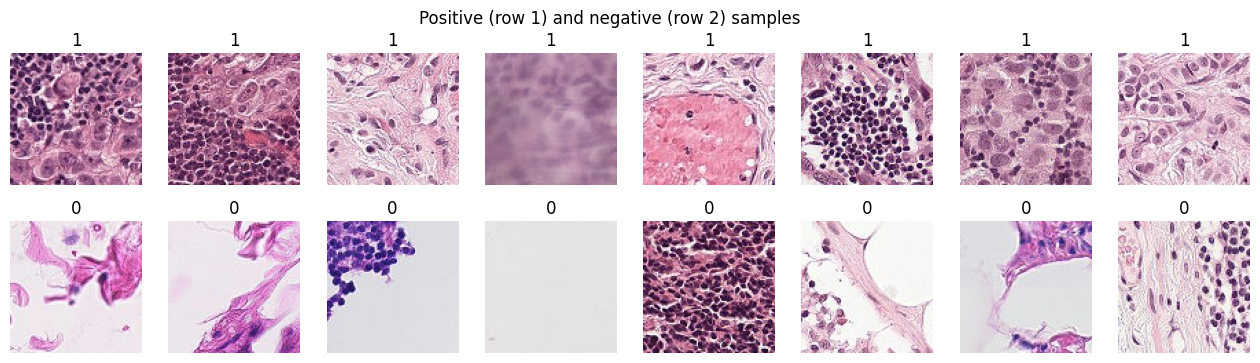

In [5]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_images_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_images_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

#### RGB Channels
- The data is provided as images broken out into 3 channels: red, green, blue (RGB). Below visualizes how the RGB channels are combined to create the orignial image.

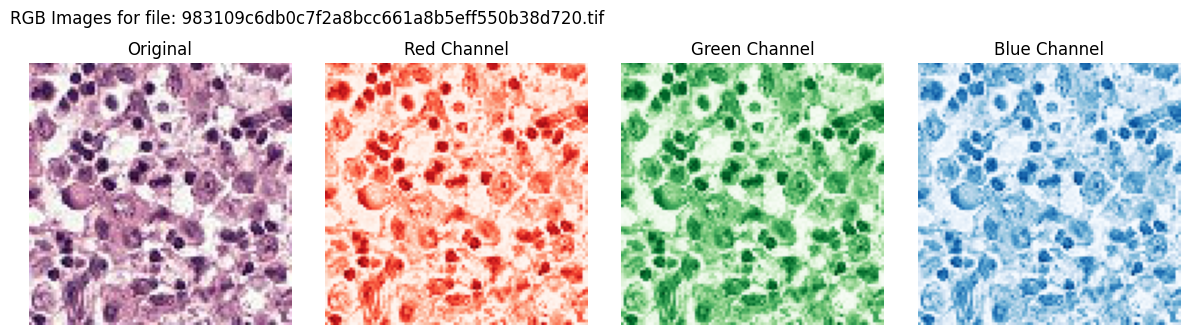

In [6]:
# Randomly select a training image
rand_idx = random.randint(0, len(os.listdir(train_images_path))+1)
filename = os.listdir(train_images_path)[rand_idx]

# Path to one example image
img_path = os.path.join(train_images_path, filename)

# Read the image (as NumPy array)
img = tiff.imread(img_path)

# Display each channel with its color
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ['Original', 'Red Channel', 'Green Channel', 'Blue Channel']
cmaps  = [None, 'Reds_r', 'Greens_r', 'Blues_r']

# Plot original RGB + individual color channels
axes[0].imshow(img)
axes[0].set_title(titles[0])
axes[0].axis('off')
for i, (title, cmap) in enumerate(zip(titles[1:], cmaps[1:])):
    axes[i+1].imshow(img[:, :, i], cmap=cmap)
    axes[i+1].set_title(title)
    axes[i+1].axis('off')
plt.tight_layout()
plt.suptitle(f'RGB Images for file: {filename}', y=1.1, horizontalalignment='right')
plt.show()

#### RGB Histograms by Label
- These plots compares the aggregated distributions of each RGB color channel for a sample of images

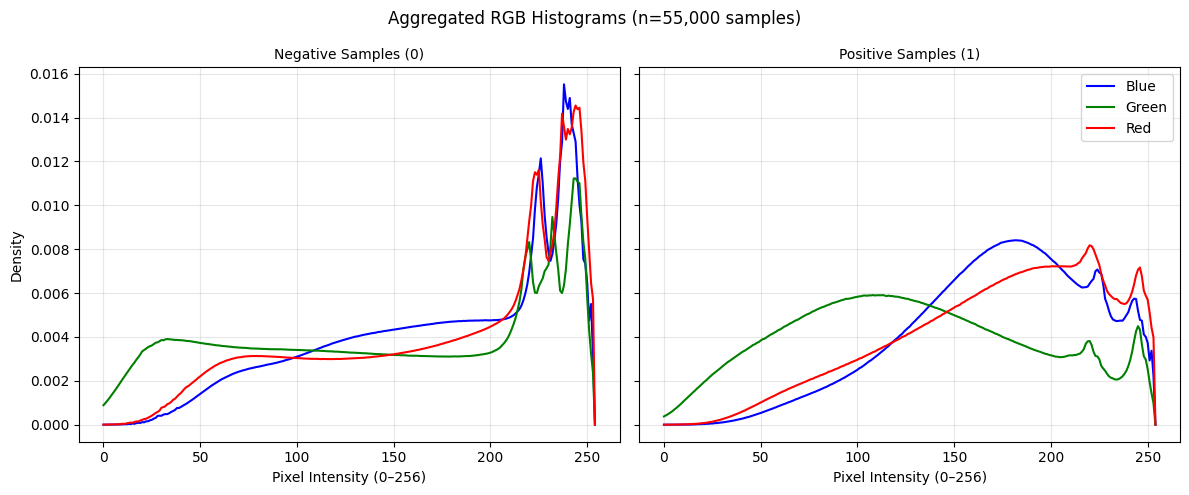

In [7]:
# Choose a random set of files from the positive (1) and negative (0) labels
n = SAMPLE_SIZE
positive_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==1]['id'].sample(n).to_list()]
negative_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==0]['id'].sample(n).to_list()]

# Function to create RGB histogram data
def get_histogram_data(files):
    hists = np.zeros((3, 255), dtype=np.float64)
    for path in files:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        for ch in range(3):
            hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
    return hists

# Get histogram data
negative_files_hist_data = get_histogram_data(negative_files)
positive_files_hist_data = get_histogram_data(positive_files)

negative_files_probability_data = negative_files_hist_data / negative_files_hist_data.sum(axis=1, keepdims=True)
positive_files_probability_data = positive_files_hist_data / positive_files_hist_data.sum(axis=1, keepdims=True)

# Plot RGB Histograms
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

ax0.plot(negative_files_probability_data[0], 'b', label='Blue')
ax0.plot(negative_files_probability_data[1], 'g', label='Green')
ax0.plot(negative_files_probability_data[2], 'r', label='Red')
ax0.set_title('Negative Samples (0)', fontdict={'fontsize':10})
ax0.set_xlabel('Pixel Intensity (0–256)')
ax0.set_ylabel('Density')
ax0.grid(True, alpha=0.3)

ax1.plot(positive_files_probability_data[0], 'b', label='Blue')
ax1.plot(positive_files_probability_data[1], 'g', label='Green')
ax1.plot(positive_files_probability_data[2], 'r', label='Red')
ax1.set_title('Positive Samples (1)', fontdict={'fontsize':10})
ax1.set_xlabel('Pixel Intensity (0–256)')
ax1.grid(True, alpha=0.3)
ax1.legend()

plt.suptitle(f'Aggregated RGB Histograms (n={n:,} samples)')
plt.tight_layout()
plt.show()

> The negative (non-cancerous) samples show sharp peaks in all three color channels near the high-intensity range (~230–250), suggesting brighter and more saturated regions, while the positive (cancerous) samples exhibit broader, smoother distributions with greater intensity spread—particularly elevated blue and green channel densities in mid-intensity ranges—indicating darker, less saturated tissue structures consistent with malignant patterns.

#### Distribution of Labels
- Visualize whether the dataset has a balanced distribution between negative (0) and positive (1) labels. To mitigate bias during training, I may explore class weighting or resampling strategies.

Class counts:
label
0    130908
1     89117
Name: count, dtype: int64


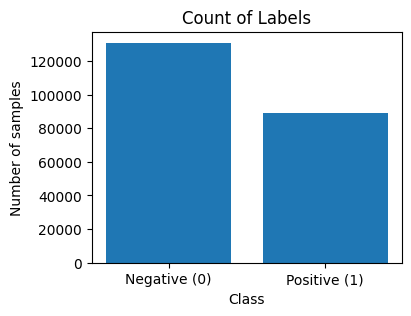

In [8]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

# Plot label distribution
plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Count of Labels')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

> The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive). This is not significant enough to affect the CNN modeling.

#### Create Training, Validation, and Test Datasets
- The Kaggle dataset only provides labels for the training images, so we will need to subdivide the training images into training (80%) and validation sets (20%) in order to be able to test the performace of the CNN models.
- I've converted the train and validation images into TensorFlow `tf.data.Dataset` objects for efficient parallel loading and model training.

In [9]:
# Load training dataset labels
train_labels_df = pd.read_csv('./train/train_labels.csv')

# Take random samples from the train_labels_df (to reduce training time)
train_labels_df = train_labels_df.sample(SAMPLE_SIZE)

# Training-Validation split
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['label'])

# Create file paths list after train-validation split
train_paths = ['./train/' + id + '.tif' for id in train_df['id']]
val_paths = ['./train/' + id + '.tif' for id in val_df['id']]

# Create label vectors after train-validation split
training_labels = train_df['label'].values
validation_labels = val_df['label'].values

# Numpy function used to read and resize images
def _read_and_resize(path):
    path = path.decode('utf-8')
    img = tiff.imread(path)       
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img.astype(np.float32)

#Function to load and preprocess each image
def load_image(path, label):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    label = tf.cast(label, tf.int32)
    return img, label

#Function to load and preprocess each image
def load_train_image(path):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    return img

# Create training and validation tf.data.Dataset instances
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, training_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, validation_labels))

# Create the test set
test_ds = tf.data.Dataset.from_tensor_slices((test_tiff_file_path_names))

# Create training dataset
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nTraining dataset of {len(training_labels):,} images has been created.')

# Create validation dataset
val_ds = (
    val_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nValidation dataset of {len(validation_labels):,} images has been created.')

# Create testing dataset
test_ds = (
    test_ds
    .map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nTesting dataset of {len(test_tiff_file_path_names):,} images has been created.')

I0000 00:00:1762715961.769972   15117 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



Training dataset of 44,000 images has been created.

Validation dataset of 11,000 images has been created.

Testing dataset of 57,458 images has been created.


#### Analysis Plan

Based on the exploratory data analysis (EDA), the following insights inform our approach:
- The dataset exhibits a moderate class imbalance; techniques such as class weighting or oversampling may be beneficial for improving model sensitivity to positive (cancerous) samples, though these will not be applied initially.
- Images show noticeable staining variability and occasional artefacts, suggesting that data augmentation (random flips, rotations, and brightness/contrast adjustments) could enhance model generalisation.

Planned analysis steps:
1. ***Data Splitting***: Divide the labelled dataset into training (80%) and validation (20%) subsets to enable model evaluation on unseen data.
2. ***Preprocessing***: Resize all images to 96×96 pixels, apply real-time data augmentation, and normalise pixel values using global channel statistics.
3. ***Baseline Model***: Develop and train an initial CNN architecture, evaluating performance on the validation set using metrics suited for imbalanced data (AUC, precision, recall, and F1-score).
4. ***Hyperparameter Tuning***: Optimise parameters such as learning rate, optimiser type, dropout rate, batch size, and network depth, then assess improvements in key performance metrics.
5. ***Transfer Learning***: Train advanced CNN models (e.g., ResNet50 and DenseNet169) to leverage pre-trained feature extraction.
6. ***Model Comparison***: Compare baseline, tuned, and transfer learning models to determine which configuration provides the best balance of accuracy, generalisation, and robustness.

## CNN Modeling
The modeling process follows a structured, incremental approach to progressively improve performance and generalisation:
1. ***Baseline Model***: Develop and train a custom CNN architecture from scratch to establish a performance benchmark on the validation dataset.
2. ***Hyperparameter Optimization***: Systematically tune key parameters such as learning rate, optimiser, dropout rate, batch size, and convolutional depth to enhance the baseline model’s accuracy and robustness.
3. ***Transfer Learning Models***: Implement and fine-tune pre-trained architectures (e.g., ResNet50, DenseNet169) to leverage learned image features and accelerate convergence.
4. ***Model Evaluation***: Evaluate all models using consistent performance metrics (AUC, accuracy, precision, recall, and F1-score) and confusion matricies to identify the best-performing architecture for cancer classification.

#### Model Fitting Helper Function
- The `fit_CNN_model` function trains a CNN while automatically managing early stopping, checkpointing, and logging. It reloads existing best weights if available, fits the model on the training and validation datasets, and returns the training history for analysis.

In [10]:
# Function used to fit the model
def fit_CNN_model(model, train_dataset, val_dataset, n_train=None, n_val=None, batch_size=BATCH_SIZE):
    # Create a checkpoint file which stores best model weights
    os.makedirs('./best_model_weights/', exist_ok=True)
    checkpoint_path = f'./best_model_weights/{model.name}_best_model.weights.h5'
    csv_path = f'./best_model_weights/{model.name}_model_history.csv'

    # Configure callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.CSVLogger(csv_path, append=os.path.exists(csv_path))
    ]
    # Fit CNN model
    if os.path.exists(checkpoint_path):
        model.load_weights(checkpoint_path)
        print(f'Loaded existing weights from {checkpoint_path}')

    history = model.fit(
        train_dataset,
        epochs=MAX_EPOCHS,
        steps_per_epoch=math.ceil(n_train / batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(n_val / batch_size),
        callbacks=callbacks,
        verbose=1,
    )

    return history

#### Model Evaluation Helper Function
- The `evaluation_outputs` function assesses model performance by generating predictions on the validation set, computing key metrics (ROC AUC and classification report), and visualizing results through a confusion matrix and learning curves for accuracy, loss, and AUC across training epochs.

In [11]:

# Function used to create evaluation outputs
def evaulation_outputs(model, model_history, validation_dataset):
    # Predict validation probabilites
    validation_probabilities = model.predict(validation_dataset, verbose=1).ravel()

    # Convert probabilites to binary labels
    validation_predicted_labels = (validation_probabilities >= 0.5).astype(np.int32)

    # Print AUC and classification report
    print(f'\nROC AUC: {roc_auc_score(validation_labels, validation_probabilities)}\n')
    print(classification_report(validation_labels, validation_predicted_labels, digits=4))

    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(
        confusion_matrix(validation_labels, validation_predicted_labels), 
        annot=True, 
        fmt='d',
        cmap='viridis',
        cbar=False,
        xticklabels=['Negative Samples (0)','Positive Samples (1)'],
        yticklabels=['Negative Samples (0)','Positive Samples (1)'],
        square=True
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Validation Confusion Matrix\n{model.name}')
    plt.tight_layout()
    plt.show()

    # Plot the learning curves
    fig, axs = plt.subplots(1, 3, figsize = (15,5))
    axs[0].set_title('Accuracy')
    axs[0].plot(model_history.epoch, model_history.history['accuracy'], label = 'Training Accuracy')
    axs[0].plot(model_history.epoch, model_history.history['val_accuracy'], label = 'Validation Accuracy')
    axs[0].legend()

    axs[1].set_title('Loss')
    axs[1].plot(model_history.epoch, model_history.history['loss'], label = 'Training Loss')
    axs[1].plot(model_history.epoch, model_history.history['val_loss'], label = 'Validation Loss')
    axs[1].legend()

    axs[2].set_title('AUC')
    axs[2].plot(model_history.epoch, model_history.history['auc'], label = 'Training AUC')
    axs[2].plot(model_history.epoch, model_history.history['val_auc'], label = 'Validation AUC')
    axs[2].legend()

#### Baseline CNN Model
- The baseline CNN model includes data augmentation, normalization, and three convolution–pooling blocks that progressively extract spatial features. The extracted features are flattened using global average pooling and passed through dense layers with dropout regularization before producing a final sigmoid output for binary cancer prediction.

In [12]:
# Function to create an instance of baseline CNN model
def build_baseline_cnn(model_name, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dropout_rate=0.5):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name='augmentation')

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = aug(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

# Create the baseline model instance
baseline_cnn_model = build_baseline_cnn('Baseline_CNN_Model')
baseline_cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

# Display baseline model structure
baseline_cnn_model.summary()

Model: "Baseline_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-11-09 12:19:25.714646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


688/688 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 0.7630 - auc: 0.8292 - loss: 0.4982 - val_accuracy: 0.7128 - val_auc: 0.8315 - val_loss: 0.6162
Epoch 2/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.7979 - auc: 0.8649 - loss: 0.4490 - val_accuracy: 0.7420 - val_auc: 0.8430 - val_loss: 0.6063
Epoch 3/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8174 - auc: 0.8852 - loss: 0.4168 - val_accuracy: 0.8092 - val_auc: 0.8881 - val_loss: 0.4286
Epoch 4/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.8267 - auc: 0.8969 - loss: 0.3965 - val_accuracy: 0.7718 - val_auc: 0.9009 - val_loss: 0.5130
Epoch 5/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.8388 - auc: 0.9083 - loss: 0.3748 - val_accuracy: 0.7871 - val_auc: 0.9072 - val_loss: 0.4597
Epoch 6/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 47s 69ms/step - accuracy: 0.8451 - auc: 0.9159 - loss: 0.3607 - val_accuracy: 0.7832 - val_auc: 0.9132 - val_loss: 0.5492
Epoch 7/30
688/688 ━━━━━━━━━━━━━━━━━━━━

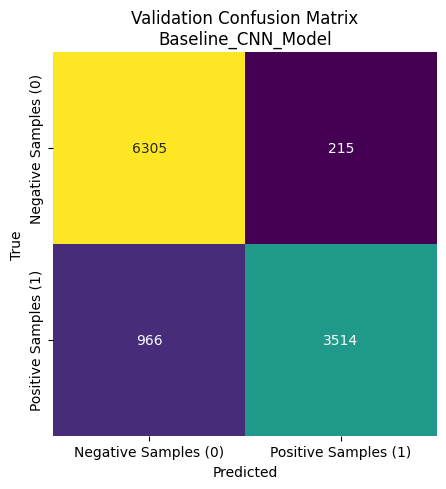

0

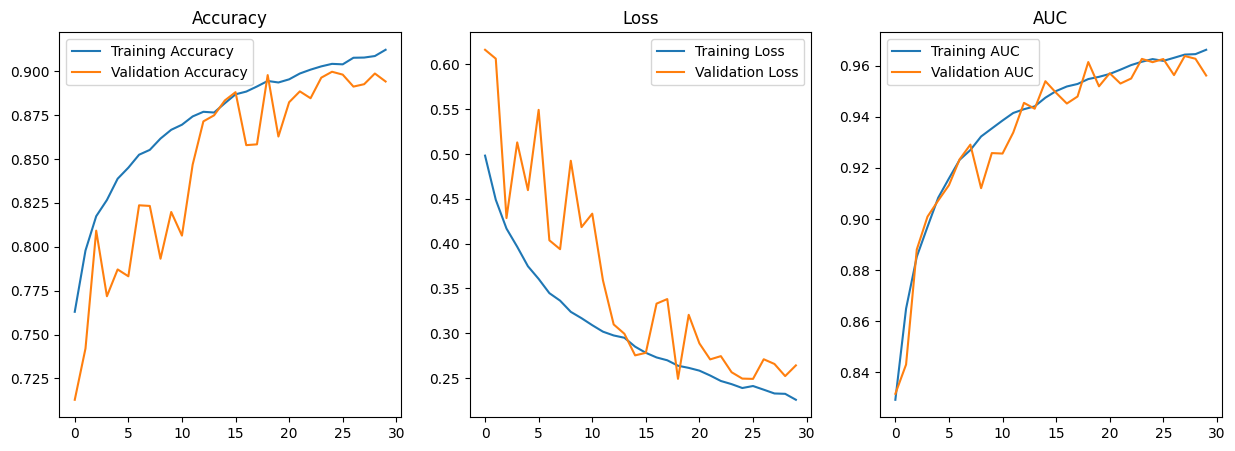

In [13]:
# Fit the baseline model
baseline_history = fit_CNN_model(
    baseline_cnn_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(baseline_cnn_model, baseline_history, val_ds)

# Remove baseline model from memory
del baseline_cnn_model
tf.keras.backend.clear_session()
gc.collect()

> The baseline CNN model performs strongly, reaching 87.2% validation accuracy and a high ROC AUC of 0.9455, which means it separates positive and negative patches very well. The confusion matrix shows slightly more missed positives (966) than false alarms (215), so recall on the cancer class is the main place left to tighten up.

## Hyperparmeter Tuning
- Next I tune the hyperparameters of the baseline CNN using Keras Tuner to identify the optimal **learning rate** and **dropout rate** for improved model performance.

#### Tuning Dropout & Learning Rates

In [14]:
# Tuning model_builder config
def model_builder(hp):
    tf.keras.backend.clear_session()
    gc.collect()
    hp_learning_rate = hp.Choice('learning_rate', [1e-4, 3e-4, 1e-3])
    hp_dropout = hp.Float('dropout', 0.3, 0.7, step=0.1)
    model = build_baseline_cnn('Tuned_Baseline_CNN_Model', input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=hp_dropout)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['auc', 'accuracy']
    )
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_auc',
    max_trials=5,
    executions_per_trial=5,
    overwrite=True,
    directory='./tuning/',
    project_name='hyperparameter_tuning_results'
)

# Run tuner on base model
tuner.search(train_ds, validation_data=val_ds, epochs=5)

# Get best dropout and learning rates
best_learning_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
best_dropout_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('dropout')
print(f'\nAfter hyperparameter tuning the best learning rate is {best_learning_rate} and the best dropout rate is {best_dropout_rate}.')

Trial 5 Complete [00h 24m 25s]
val_auc: 0.8628706336021423

Best val_auc So Far: 0.906839919090271
Total elapsed time: 01h 56m 03s

After hyperparameter tuning the best learning rate is 0.001 and the best dropout rate is 0.4.


In [15]:
# Hyperparameter tuning summary
tuner.results_summary()

Results summary
Results in ./tuning/hyperparameter_tuning_results
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 2 summary
Hyperparameters:
learning_rate: 0.001
dropout: 0.4
Score: 0.906839919090271

Trial 0 summary
Hyperparameters:
learning_rate: 0.001
dropout: 0.5
Score: 0.8934475064277649

Trial 4 summary
Hyperparameters:
learning_rate: 0.0003
dropout: 0.6000000000000001
Score: 0.8628706336021423

Trial 3 summary
Hyperparameters:
learning_rate: 0.0003
dropout: 0.3
Score: 0.8510504961013794

Trial 1 summary
Hyperparameters:
learning_rate: 0.0001
dropout: 0.4
Score: 0.80790034532547


> Hyperparameter tuning showed that a learning rate of 0.001 and a dropout rate of 0.4 produced the best validation AUC (0.9068), outperforming lower learning rates and higher dropout values, indicating this combination provides the optimal balance between learning stability and generalization.

#### Hyperparmeter Tuned Baseline CNN Model
- Applying the best learning and dropout rates to the baseline CNN model.

In [16]:
# Create the baseline model instance
tuned_baseline_cnn_model = build_baseline_cnn('Tuned_Baseline_CNN_Model', dropout_rate=best_dropout_rate)
tuned_baseline_cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

# Display baseline model structure
tuned_baseline_cnn_model.summary()

Model: "Tuned_Baseline_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.7559 - auc: 0.8183 - loss: 0.5111 - val_accuracy: 0.7092 - val_auc: 0.8277 - val_loss: 0.6371
Epoch 2/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.7916 - auc: 0.8619 - loss: 0.4536 - val_accuracy: 0.7255 - val_auc: 0.8424 - val_loss: 0.6059
Epoch 3/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.8082 - auc: 0.8786 - loss: 0.4272 - val_accuracy: 0.7073 - val_auc: 0.8322 - val_loss: 0.6126
Epoch 4/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.8247 - auc: 0.8954 - loss: 0.3983 - val_accuracy: 0.7153 - val_auc: 0.8551 - val_loss: 0.6444
Epoch 5/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8344 - auc: 0.9067 - loss: 0.3776 - val_accuracy: 0.8125 - val_auc: 0.8952 - val_loss: 0.4319
Epoch 6/30
688/688 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.8428 - auc: 0.9142 - loss: 0.3635 - val_accuracy: 0.8048 - val_auc: 0.9237 - val_loss: 0.4377
Epoch 7/30
688/688 ━━━━━━━━━

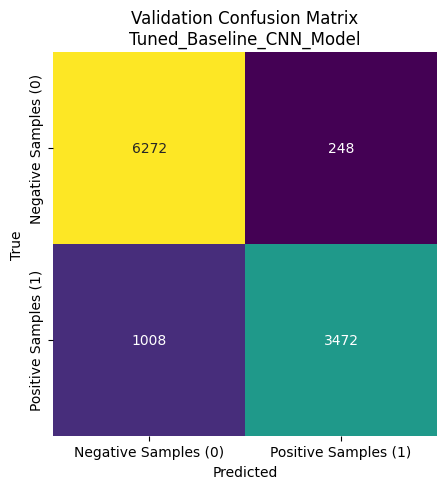

0

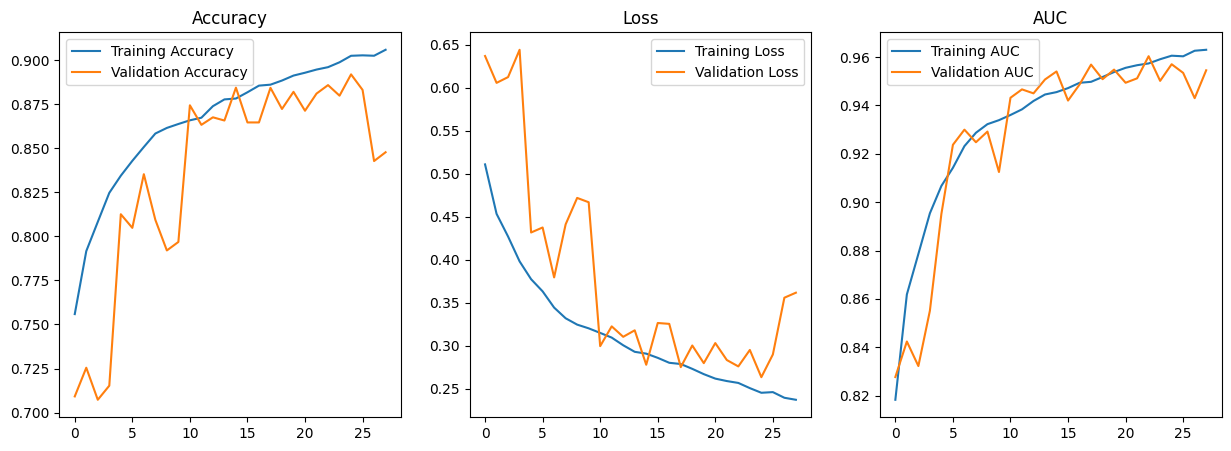

In [17]:
# Fit the baseline model
tuned_baseline_cnn_model_history = fit_CNN_model(
    tuned_baseline_cnn_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(tuned_baseline_cnn_model, tuned_baseline_cnn_model_history, val_ds)

# Remove tuned baseline model from memory
del tuned_baseline_cnn_model
tf.keras.backend.clear_session()
gc.collect()

> The hyperparameter-tuned model also achieves high performance similar to the original baseline, with a validation accuracy of 86.3% and ROC AUC of ~0.9606. Also, the tuned model had a small increase in false positives when compared to the baseline (1008 vs 966). These metrics suggests the baseline configuration was already near-optimal, and the tuned settings did not necessarily translate into better validation generalization.

## CNN Transfer Models
- Next I chose to apply the **ResNet50** and **DenseNet169** transfer models to the baseline CNN.
- Transfer models are models that have been pre-trained on large and diverse datasets such as ImageNet, enabling them to learn complex visual features that can be effectively repurposed for medical image classification tasks. By fine-tuning these architectures on the cancer detection dataset, the models can achieve improved accuracy, faster convergence, and better generalization compared to training a CNN from scratch, particularly given the limited size and domain-specific nature of the dataset.

#### Transfer Models Helper Function

In [18]:
# Function to create a CNN transfer model
def build_transfer_model(model_name, base_transer_model, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dropout_rate=0.3):
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name='augmentation')
    
    base_transer_model.trainable = False  # freeze base model

    inputs = tf.keras.Input(shape=input_shape)
    x = aug(inputs)
    x = preprocess_input(x)
    x = base_transer_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs, name=model_name)
    
    return model

#### ResNet50 CNN Transfer Model
- ResNet50 (Residual Network with 50 layers) uses skip connections to allow gradients to flow through the network more effectively, solving the vanishing gradient problem and enabling very deep models to learn efficiently.

In [23]:
# ResNet50 model
resnet_base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
resnet_model = build_transfer_model('ResNet50_Model', resnet_base_model, dropout_rate=0.3)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

resnet_model.summary()

# Fit the ResNet50 transfer model for 5 epochs (with a frozen backbone)
resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=5
)

Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 96, 96, 3) │          0 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 96, 96)    │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 96, 96)    │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 96, 96)    │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_6[0][0], │
│                     │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 96, 96, 3) │          0 │ stack_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 3, 3,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      2,049 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 84s 116ms/step - accuracy: 0.6976 - auc: 0.7516 - loss: 0.6529 - val_accuracy: 0.7896 - val_auc: 0.8607 - val_loss: 0.4735
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 83s 121ms/step - accuracy: 0.7928 - auc: 0.8606 - loss: 0.4690 - val_accuracy: 0.8093 - val_auc: 0.8881 - val_loss: 0.4347
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 88s 127ms/step - accuracy: 0.8112 - auc: 0.8808 - loss: 0.4298 - val_accuracy: 0.8118 - val_auc: 0.8991 - val_loss: 0.4284
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 89s 129ms/step - accuracy: 0.8213 - auc: 0.8932 - loss: 0.4043 - val_accuracy: 0.8205 - val_auc: 0.9048 - val_loss: 0.4088
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 90s 130ms/step - accuracy: 0.8308 - auc: 0.9004 - loss: 0.3899 - val_accuracy: 0.8216 - val_auc: 0.9108 - val_loss: 0.4056


Epoch 1/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 144s 189ms/step - accuracy: 0.8217 - auc: 0.8980 - loss: 0.4997 - val_accuracy: 0.8577 - val_auc: 0.9277 - val_loss: 0.3409
Epoch 2/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 124s 180ms/step - accuracy: 0.8545 - auc: 0.9317 - loss: 0.4029 - val_accuracy: 0.8636 - val_auc: 0.9380 - val_loss: 0.3247
Epoch 3/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 125s 181ms/step - accuracy: 0.8692 - auc: 0.9427 - loss: 0.3683 - val_accuracy: 0.8715 - val_auc: 0.9438 - val_loss: 0.3151
Epoch 4/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 124s 180ms/step - accuracy: 0.8825 - auc: 0.9503 - loss: 0.3425 - val_accuracy: 0.8829 - val_auc: 0.9491 - val_loss: 0.2888
Epoch 5/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 125s 182ms/step - accuracy: 0.8896 - auc: 0.9561 - loss: 0.3216 - val_accuracy: 0.8841 - val_auc: 0.9526 - val_loss: 0.2838
Epoch 6/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 141s 180ms/step - accuracy: 0.8947 - auc: 0.9599 - loss: 0.3071 - val_accuracy: 0.8915 - val_auc: 0.9554 - val_loss: 0.2715
Epoch 7/25
688/6

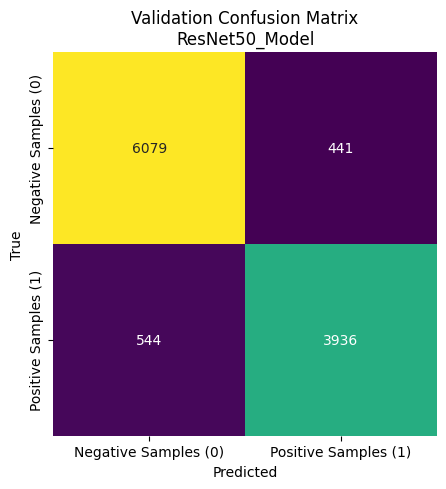

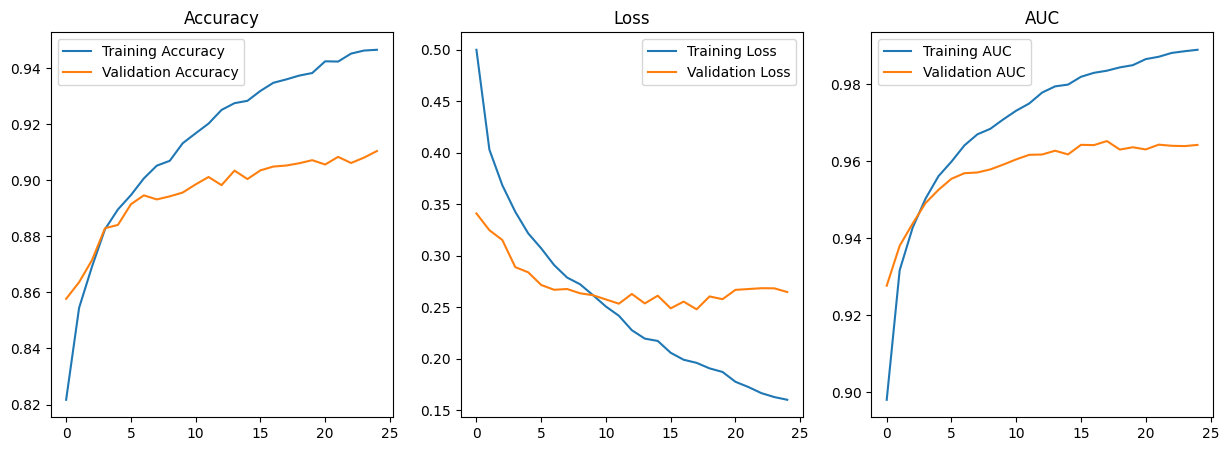

In [24]:
# Fine tune resnet_base_model by unfreezing last 50 layers
resnet_base_model.trainable = True
for layer in resnet_base_model.layers[:-50]:
    layer.trainable = False

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

# Re-fit model
resnet_model_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=25,
    class_weight={0: 1.0, 1: 1.5}
)

# Create evaluation metrics
evaulation_outputs(resnet_model, resnet_model_history, val_ds)

> The ResNet50 transfer model achieved strong performance, reaching 91.1% accuracy and an AUC of 0.9662, demonstrating effective feature extraction from pre-trained ImageNet weights. While the model performs slightly below the baseline CNN in overall accuracy, its smoother convergence and balanced precision-recall indicate that it generalizes well and effectively captures complex image patterns with fewer training epochs.

#### DenseNet169 CNN Transfer Model
- DenseNet169 (Densely Connected Network with 169 layers) connects each layer to every other layer in a feed-forward fashion, promoting feature reuse and reducing the number of parameters needed for strong performance.
- DenseNet is already heavily regularized through dense connectivity, so I'm reducing dropout to 0.2.

In [27]:
# DenseNet169 transfer model
densenet_base_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
densenet_model = build_transfer_model('DenseNet169_Model', densenet_base_model, dropout_rate=0.2)
densenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

densenet_model.summary()

# Fit the DenseNet169 transfer model for 5 epochs (with a frozen backbone)
densenet_model.fit(train_ds, validation_data=val_ds, epochs=5)

Model: "DenseNet169_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 96, 96, 3) │          0 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 96, 96)    │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 96, 96)    │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 96, 96)    │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_12[0][0… │
│                     │                   │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 96, 96, 3) │          0 │ stack_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 3, 3,      │ 12,642,880 │ add_4[0][0]       │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      1,665 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,644,545 (48.24 MB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 118s 156ms/step - accuracy: 0.6902 - auc: 0.7224 - loss: 2.0921 - val_accuracy: 0.6674 - val_auc: 0.6570 - val_loss: 1.7985
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 104s 151ms/step - accuracy: 0.7416 - auc: 0.7924 - loss: 1.2766 - val_accuracy: 0.6884 - val_auc: 0.6980 - val_loss: 1.4108
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 111s 161ms/step - accuracy: 0.7606 - auc: 0.8221 - loss: 0.9318 - val_accuracy: 0.6936 - val_auc: 0.7496 - val_loss: 1.3252
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 114s 165ms/step - accuracy: 0.7759 - auc: 0.8445 - loss: 0.7279 - val_accuracy: 0.6995 - val_auc: 0.7755 - val_loss: 1.1367
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 116s 168ms/step - accuracy: 0.7859 - auc: 0.8596 - loss: 0.5913 - val_accuracy: 0.6915 - val_auc: 0.7918 - val_loss: 1.1124


Epoch 1/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 141s 169ms/step - accuracy: 0.8117 - auc: 0.8865 - loss: 0.5249 - val_accuracy: 0.7807 - val_auc: 0.8659 - val_loss: 0.4821
Epoch 2/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - accuracy: 0.8328 - auc: 0.9132 - loss: 0.4522 - val_accuracy: 0.7987 - val_auc: 0.8813 - val_loss: 0.4453
Epoch 3/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.8422 - auc: 0.9210 - loss: 0.4311 - val_accuracy: 0.7984 - val_auc: 0.8869 - val_loss: 0.4438
Epoch 4/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 133s 193ms/step - accuracy: 0.8493 - auc: 0.9271 - loss: 0.4147 - val_accuracy: 0.7979 - val_auc: 0.8802 - val_loss: 0.4508
Epoch 5/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 133s 193ms/step - accuracy: 0.8588 - auc: 0.9335 - loss: 0.3965 - val_accuracy: 0.7934 - val_auc: 0.8757 - val_loss: 0.4806
Epoch 6/25
688/688 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.8608 - auc: 0.9355 - loss: 0.3903 - val_accuracy: 0.7895 - val_auc: 0.8843 - val_loss: 0.4922
Epoch 7/25
688/6

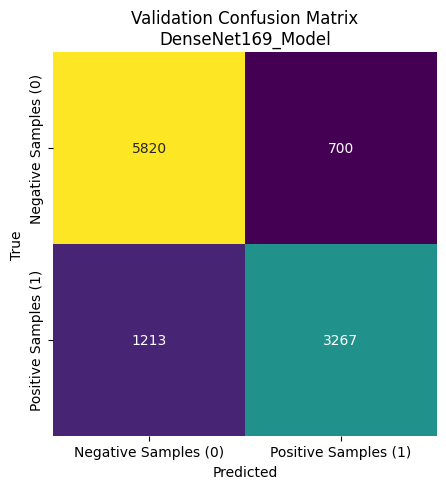

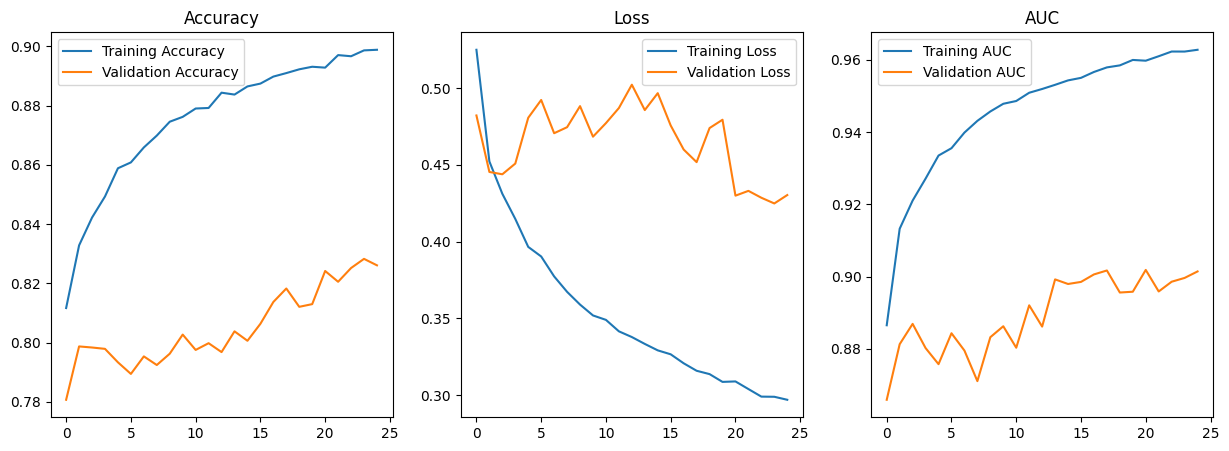

In [28]:
# Fine tune the densenet_base_model by unfreezing last 60 layers
densenet_base_model.trainable = True
for layer in densenet_base_model.layers[:-60]:
    layer.trainable = False

densenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['auc', 'accuracy']
)

# Re-fit model
densenet_model_history = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=25,
    class_weight={0: 1.0, 1: 1.5}
)

# Create evaluation metrics
evaulation_outputs(densenet_model, densenet_model_history, val_ds)

> The DenseNet169 transfer model converged but did not match the performance of the baseline CNN or the ResNet50 model, leveling off around 82–83% validation accuracy and ~0.90 AUC, with noticeably higher validation loss and more false negatives (1,213). This indicates the model was underfitting the validation data—likely because only the top layers were trainable—so it was unable to fully adapt DenseNet’s ImageNet features to the pathology domain.

## Results & Analysis
The final AUC and accuracy values for each model are:

| Model       | ROC AUC    | Accuracy   |
|-------------|------------|------------|
| Base CNN    | 0.9640     | 0.8926     |
| Tuned Base  | 0.9606     | 0.8858     |
| ResNet50    | **0.9662** | **0.9105** |
| DenseNet169 | 0.9019     | 0.8261     |

Across the four models evaluated, the transfer learning approach with ResNet50 provided the strongest overall performance, achieving the highest ROC AUC (0.9662) and accuracy (0.9105), indicating it was best at distinguishing metastatic (label 1) from non-metastatic (label 0) patches while also making the most correct classifications. The baseline CNN also performed well (AUC 0.9640, accuracy 0.8926), showing that a carefully designed custom model can approach the performance of a large pre-trained network on this task. Hyperparameter tuning of the baseline CNN did not yield further gains and in fact led to a slight decline in both AUC (0.9606) and accuracy (0.8858), suggesting the original configuration was already near its optimal capacity. In contrast, the DenseNet169 transfer model lagged behind the other three models (AUC 0.9019, accuracy 0.8261), reflecting underfitting and less effective adaptation of its pre-trained features to this dataset.

#### Kaggle Submission

In [ ]:
# Get best model
best_model = resnet_model

# Predict labels for test images

# Predict validation probabilites
test_probabilities = best_model.predict(test_ds, verbose=1).ravel()

# Convert probabilites to binary labels
test_predicted_labels = (test_probabilities >= 0.5).astype(np.int32)

# Extract ids from test_ids_list
pattern = re.compile(r'([a-f0-9]{40})(?=\.tif$)', re.IGNORECASE)
test_ids = [pattern.search(p).group(1) for p in test_tiff_file_path_names if pattern.search(p)]

# Create submission_df and save to directory
submission_df = pd.DataFrame({'id': test_ids, 'label': test_predicted_labels})
submission_df.to_csv('submission_df.csv', index=False)
submission_df

898/898 ━━━━━━━━━━━━━━━━━━━━ 75s 82ms/step


2025-11-09 20:31:00.374873: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


,id,label
0,5b00f00416e1a528723aa55437144ac5ab0aa2f0,1
1,b5a489eeec3b527376545944a5752d5c6cf42b67,0
2,215bdc58a5dcf7974aaf6f3b35256a24ed045d83,0
3,940650a72d99e51d98920a78f2746aced50e2b23,0
4,85cbdcb02982ef12f2ed665ffd90990c37f6af1d,0
...,...,...
57453,337e01394df3cf7363cfd83fe05db908b3d8384c,0
57454,482ac1128e07f294197370c39a0e42a10e8aa4fb,0
57455,05be3dd4004205bf11cccfdaab026028b531ee6e,0
57456,d966469ae7ac39fc3cf5236ed56f8c71d221a600,0


In [37]:
# Image of Kaggle submission
Image(url='submission_screenshot.png')

## Conclusion
This project applied convolutional neural networks (CNNs) to the task of metastatic cancer detection using small histopathologic image patches. The workflow progressed from building and evaluating a custom baseline CNN to optimizing it through hyperparameter tuning and, finally, implementing transfer learning using pre-trained architectures (ResNet50 and DenseNet169). The results demonstrated that transfer learning with ResNet50 provided the best overall performance, achieving the highest ROC AUC and accuracy, while the baseline CNN also produced strong results, confirming the effectiveness of CNNs for this classification task.

A key takeaway from this project was the importance of leveraging pre-trained models for feature extraction and faster convergence, as they significantly improved generalization on complex image data compared to training from scratch. Conversely, hyperparameter tuning of the baseline model did not lead to performance gains, suggesting that the architecture and parameters were already well-suited for the dataset. The DenseNet169 model, while theoretically powerful, underperformed due to limited fine-tuning and possible underfitting, indicating that not all transfer models adapt equally well to specialized medical imagery.

Future improvements could include fine-tuning deeper layers of the pre-trained networks to better adapt to histopathologic features, applying advanced regularization methods such as batch normalization or learning rate scheduling, and experimenting with larger input sizes or higher-resolution datasets. Additionally, employing ensemble learning or attention-based architectures could further enhance classification accuracy and model interpretability, supporting more reliable cancer detection outcomes.